In [71]:
# Chapter 3 Classification Walkthrough - Titanic Dataset

In [ ]:
>>> import matplotlib.pyplot as plt
>>> import pandas as pd
>>> from sklearn import (
...     ensemble,
...     model_selection,    
...     preprocessing,
...     tree,
... )
>>> from sklearn.metrics import (
...     auc,
...     confusion_matrix,
...     roc_auc_score,
...     roc_curve,
... )
>>> from sklearn.model_selection import (
...     train_test_split,
...     StratifiedKFold,
... )

In [39]:
import warnings
warnings.filterwarnings("ignore")

In [3]:
>>> from yellowbrick.classifier import (
...     ConfusionMatrix,
...     ROCAUC,
... )
>>> from yellowbrick.model_selection import (
...     LearningCurve,
... )

In [9]:
>>> df = pd.read_excel("titanic3.xlsx")
>>> orig_df = df

In [10]:
>>> df.dtypes

pclass         int64
survived       int64
name          object
sex           object
age          float64
sibsp          int64
parch          int64
ticket        object
fare         float64
cabin         object
embarked      object
boat          object
body         float64
home.dest     object
dtype: object

In [12]:
>>> df.shape

(1309, 14)

In [13]:
>>> df.describe().iloc[:, :2]

,pclass,survived
count,1309.000000,1309.000000
mean,2.294882,0.381971
std,0.837836,0.486055
min,1.000000,0.000000
25%,2.000000,0.000000
50%,3.000000,0.000000
75%,3.000000,1.000000
max,3.000000,1.000000


In [14]:
>>> df.isnull().sum()

pclass          0
survived        0
name            0
sex             0
age           263
sibsp           0
parch           0
ticket          0
fare            1
cabin        1014
embarked        2
boat          823
body         1188
home.dest     564
dtype: int64

In [15]:
>>> df.isnull().sum(axis=1).loc[:10]

0     1
1     1
2     2
3     1
4     2
5     1
6     1
7     2
8     1
9     2
10    1
dtype: int64

In [16]:
>>> mask = df.isnull().any(axis=1)

In [17]:
>>> mask.head()  # rows

0    True
1    True
2    True
3    True
4    True
dtype: bool

In [18]:
>>> df[mask].body.head()

0      NaN
1      NaN
2      NaN
3    135.0
4      NaN
Name: body, dtype: float64

In [19]:
>>> df.sex.value_counts(dropna=False)

male      843
female    466
Name: sex, dtype: int64

In [20]:
>>> df.embarked.value_counts(dropna=False)

S      914
C      270
Q      123
NaN      2
Name: embarked, dtype: int64

In [21]:
>>> name = df.name
>>> name.head(3)

0     Allen, Miss. Elisabeth Walton
1    Allison, Master. Hudson Trevor
2      Allison, Miss. Helen Loraine
Name: name, dtype: object

In [22]:
>>> df = df.drop(
...     columns=[
...         "name",
...         "ticket",
...         "home.dest",
...         "boat",
...         "body",
...         "cabin",
...     ]
... )

In [23]:
>>> df = pd.get_dummies(df)

In [24]:
>>> df.columns

Index(['pclass', 'survived', 'age', 'sibsp', 'parch', 'fare', 'sex_female',
       'sex_male', 'embarked_C', 'embarked_Q', 'embarked_S'],
      dtype='object')

In [25]:
>>> df = df.drop(columns="sex_male")

In [26]:
>>> df = pd.get_dummies(df, drop_first=True)

In [27]:
>>> df.columns

Index(['pclass', 'survived', 'age', 'sibsp', 'parch', 'fare', 'sex_female',
       'embarked_C', 'embarked_Q', 'embarked_S'],
      dtype='object')

In [28]:
>>> y = df.survived
>>> X = df.drop(columns="survived")

In [34]:
>>> import janitor as jn

ModuleNotFoundError: No module named 'ConfigParser'

In [32]:
>>> import janitor as jn
>>> X, y = jn.get_features_targets(
...     df, target_columns="survived"
... )

ModuleNotFoundError: No module named 'ConfigParser'

In [35]:
>>> X_train, X_test, y_train, y_test = model_selection.train_test_split(
...     X, y, test_size=0.3, random_state=42
... )

In [36]:
X_train.columns

Index(['pclass', 'age', 'sibsp', 'parch', 'fare', 'sex_female', 'embarked_C',
       'embarked_Q', 'embarked_S'],
      dtype='object')

In [37]:
>>> from sklearn.experimental import (
...     enable_iterative_imputer,
... )
>>> from sklearn import impute
>>> num_cols = [
...     "pclass",
...     "age",
...     "sibsp",
...     "parch",
...     "fare",
...     "sex_female",
... ]

In [40]:
>>> imputer = impute.IterativeImputer()
>>> imputed = imputer.fit_transform(
...     X_train[num_cols]
... )
>>> X_train.loc[:, num_cols] = imputed
>>> imputed = imputer.transform(X_test[num_cols])
>>> X_test.loc[:, num_cols] = imputed

In [41]:
>>> meds = X_train.median()
>>> X_train = X_train.fillna(meds)
>>> X_test = X_test.fillna(meds)

In [42]:
num_cols

['pclass', 'age', 'sibsp', 'parch', 'fare', 'sex_female']

In [43]:
X_train.shape

(916, 9)

In [44]:
>>> cols = ['pclass', 'age', 'sibsp', 'parch', 'fare', 'sex_female', 'embarked_C',
       'embarked_Q', 'embarked_S']
>>> sca = preprocessing.StandardScaler()
>>> X_train = sca.fit_transform(X_train)
>>> X_train = pd.DataFrame(X_train, columns=cols)
>>> X_test = sca.transform(X_test)
>>> X_test = pd.DataFrame(X_test, columns=cols)

In [45]:
>>> def tweak_titanic(df):
...     df = df.drop(
...         columns=[
...             "name",
...             "ticket",
...             "home.dest",
...             "boat",
...             "body",
...             "cabin",
...         ]
...     ).pipe(pd.get_dummies, drop_first=True)
...     return df

In [46]:
>>> def get_train_test_X_y(
...     df, y_col, size=0.3, std_cols=None
... ):
...     y = df[y_col]
...     X = df.drop(columns=y_col)
...     X_train, X_test, y_train, y_test = model_selection.train_test_split(
...         X, y, test_size=size, random_state=42
...     )
...     cols = X.columns
...     num_cols = [
...         "pclass",
...         "age",
...         "sibsp",
...         "parch",
...         "fare",
...     ]
...     fi = impute.IterativeImputer()
...     X_train.loc[
...         :, num_cols
...     ] = fi.fit_transform(X_train[num_cols])
...     X_test.loc[:, num_cols] = fi.transform(
...         X_test[num_cols]
...     )
...
...     if std_cols:
...         std = preprocessing.StandardScaler()
...         X_train.loc[
...             :, std_cols
...         ] = std.fit_transform(
...             X_train[std_cols]
...         )
...         X_test.loc[
...             :, std_cols
...         ] = std.transform(X_test[std_cols])
...
...     return X_train, X_test, y_train, y_test

In [47]:
>>> ti_df = tweak_titanic(orig_df)
>>> std_cols = "pclass,age,sibsp,fare".split(",")
>>> X_train, X_test, y_train, y_test = get_train_test_X_y(
...     ti_df, "survived", std_cols=std_cols
... )

In [48]:
>>> from sklearn.dummy import DummyClassifier
>>> bm = DummyClassifier()
>>> bm.fit(X_train, y_train)
>>> bm.score(X_test, y_test)  # accuracy

0.544529262086514

In [49]:
>>> from sklearn import metrics
>>> metrics.precision_score(
...     y_test, bm.predict(X_test)
... )

0.44

In [51]:
>>> X = pd.concat([X_train, X_test])
>>> y = pd.concat([y_train, y_test])
>>> from sklearn import model_selection
>>> from sklearn.dummy import DummyClassifier
>>> from sklearn.linear_model import (
...     LogisticRegression,
... )
>>> from sklearn.tree import DecisionTreeClassifier
>>> from sklearn.neighbors import (
...     KNeighborsClassifier,
... )
>>> from sklearn.naive_bayes import GaussianNB
>>> from sklearn.svm import SVC
>>> from sklearn.ensemble import (
...     RandomForestClassifier,
... )
>>> import xgboost

In [52]:
>>> for model in [
...     DummyClassifier,
...     LogisticRegression,
...     DecisionTreeClassifier,
...     KNeighborsClassifier,
...     GaussianNB,
...     SVC,
...     RandomForestClassifier,
...     xgboost.XGBClassifier,
... ]:
...     cls = model()
...     kfold = model_selection.KFold(
...         n_splits=10, random_state=42
...     )
...     s = model_selection.cross_val_score(
...         cls, X, y, scoring="roc_auc", cv=kfold
...     )
...     print(
...         f"{model.__name__:22}  AUC: "
...         f"{s.mean():.3f} STD: {s.std():.2f}"
...     )

DummyClassifier         AUC: 0.510 STD: 0.03
LogisticRegression      AUC: 0.843 STD: 0.03
DecisionTreeClassifier  AUC: 0.764 STD: 0.04
KNeighborsClassifier    AUC: 0.830 STD: 0.05
GaussianNB              AUC: 0.817 STD: 0.04
SVC                     AUC: 0.838 STD: 0.05
RandomForestClassifier  AUC: 0.838 STD: 0.04
XGBClassifier           AUC: 0.863 STD: 0.04


In [59]:
>>> rf = ensemble.RandomForestClassifier(
...     n_estimators=100, random_state=42
... )
>>> rf.fit(X_train, y_train)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
                       max_depth=None, max_features='auto', max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=100,
                       n_jobs=None, oob_score=False, random_state=42, verbose=0,
                       warm_start=False)

In [60]:
>>> rf.score(X_test, y_test)

0.7811704834605598

In [61]:
>>> metrics.precision_score(
...     y_test, rf.predict(X_test)
... )

0.7862068965517242

In [62]:
>>> for col, val in sorted(
...     zip(
...         X_train.columns,
...         rf.feature_importances_,
...     ),
...     key=lambda x: x[1],
...     reverse=True,
... )[:5]:
...     print(f"{col:10}{val:10.3f}")

age            0.285
fare           0.262
sex_male       0.241
pclass         0.089
sibsp          0.050


In [63]:
>>> rf4 = ensemble.RandomForestClassifier()
>>> params = {
...     "max_features": [0.4, "auto"],
...     "n_estimators": [15, 200],
...     "min_samples_leaf": [1, 0.1],
...     "random_state": [42],
... }
>>> cv = model_selection.GridSearchCV(
...     rf4, params, n_jobs=-1
... ).fit(X_train, y_train)
>>> print(cv.best_params_)

{'max_features': 'auto', 'min_samples_leaf': 0.1, 'n_estimators': 15, 'random_state': 42}


In [64]:
>>> rf5 = ensemble.RandomForestClassifier(
...     **{
...         "max_features": "auto",
...         "min_samples_leaf": 0.1,
...         "n_estimators": 200,
...         "random_state": 42,
...     }
... )
>>> rf5.fit(X_train, y_train)
>>> rf5.score(X_test, y_test)

0.7073791348600509

In [65]:
>>> from sklearn.metrics import confusion_matrix
>>> y_pred = rf5.predict(X_test)
>>> confusion_matrix(y_test, y_pred)

array([[217,   7],
       [108,  61]], dtype=int64)

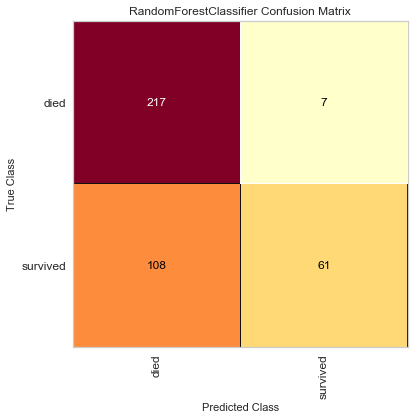

In [66]:
>>> mapping = {0: "died", 1: "survived"}
>>> fig, ax = plt.subplots(figsize=(6, 6))
>>> cm_viz = ConfusionMatrix(
...     rf5,
...     classes=["died", "survived"],
...     label_encoder=mapping,
... )
>>> cm_viz.score(X_test, y_test)
>>> cm_viz.poof()

In [67]:
>>> y_pred = rf5.predict(X_test)
>>> roc_auc_score(y_test, y_pred)

0.6648483727810651

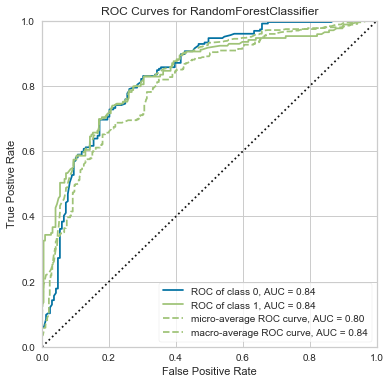

In [68]:
>>> fig, ax = plt.subplots(figsize=(6, 6))
>>> roc_viz = ROCAUC(rf5)
>>> roc_viz.score(X_test, y_test)
>>> roc_viz.poof()

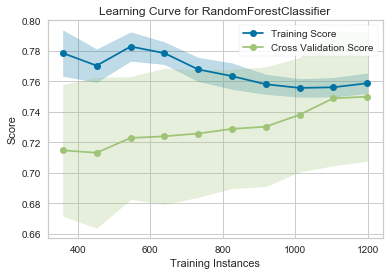

In [69]:
>>> import numpy as np
>>> fig, ax = plt.subplots(figsize=(6, 4))
>>> cv = StratifiedKFold(12)
>>> sizes = np.linspace(0.3, 1.0, 10)
>>> lc_viz = LearningCurve(
...     rf5,
...     cv=cv,
...     train_sizes=sizes,
...     scoring="f1_weighted",
...     n_jobs=4,
...     ax=ax,
... )
>>> lc_viz.fit(X, y)
>>> lc_viz.poof()

In [70]:
>>> import pickle
>>> pic = pickle.dumps(rf5)
>>> rf6 = pickle.loads(pic)
>>> y_pred = rf6.predict(X_test)
>>> roc_auc_score(y_test, y_pred)

0.6648483727810651